# Convert Haystacks cube

Populating the interactive namespace from numpy and matplotlib
(11, 201, 201)


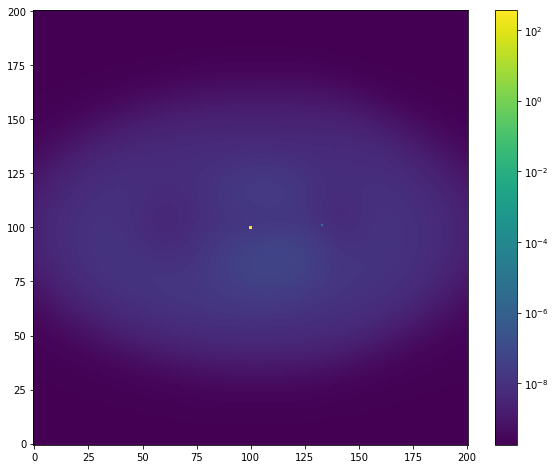

In [1]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
from matplotlib.colors import LogNorm

from astropy.io import fits
import astropy.units as u
import astropy.constants as c


cmap='viridis'
filename = '/Users/mrizzo/Science/Haystacks/cube_zodi10inc60dist3_epoch25.7300_sres50.0000_0.4um'
hducube = fits.open(filename+'.fits')
print(hducube[0].shape)
img = hducube[0].data
plt.figure(figsize=(12,8))
plt.imshow(img[0],cmap=cmap,norm=LogNorm())
plt.colorbar(fraction=0.046, pad=0.04)

In [2]:
lamlist = (hducube[1].data*u.um).to(u.nm)
print lamlist

[ 450.          459.99996948  470.          480.          489.99996948
  500.          510.          520.          530.          539.99993896
  549.99993896] nm


In [3]:

imgJy = img*(1.*u.Jansky)
imgJy = imgJy.to(u.Watt/u.m**2/u.Hertz)

wavelcube = c.c/lamlist[:,np.newaxis,np.newaxis]**2
imgJy *= wavelcube
print(imgJy[0,0,0])
imgJy = imgJy.to(u.W/u.m**2/u.nm)
E_ph = (c.h*c.c/lamlist[:,np.newaxis,np.newaxis]).to(u.J)
imgphots = (imgJy/E_ph).to(1./u.s/u.m**2/u.nm)

print(np.sum(imgphots[0]))


2.71995728256e-33 W / (Hz m nm2 s)
12280787.9721 1 / (m2 nm s)


In [4]:
dlam = 10*u.nm
area = (2.37*u.m)**2
imgphotspersec = imgphots * dlam*area
print(np.amax(imgphotspersec[-1]))


764141548.927 1 / s


In [5]:
header = hducube[0].header
header['BUNIT']='ph/s/nm/m2'
header.append(('COMMENT', 'Converted to photons/sec/m2/nm/pixel'), end=True)
outkey = fits.HDUList(fits.PrimaryHDU(imgphots.value,header))
outkey.append(hducube[1])
outkey.append(hducube[2])
outkey.writeto(filename+'_phpersec_test.fits', clobber=True)


In [6]:
import sys
import os

folder = '../../../../crispy'
print(folder)
if folder not in sys.path: sys.path.append(folder)


../../../../crispy


# Integrate into crispy

In [7]:
from crispy.tools.inputScene import convert_haystacks_cube

newhdu = convert_haystacks_cube(hducube)
newhdu.writeto(filename+'_phpersec.fits',clobber=True)